# Introduction

In this project, we are designing a controller that will balance a pendulum upright. This is exactly like trying to balance an upright pencil in the palm of your hand by moving your hand around. In this problem, a mass is attached to the end of a rigid, massless rod. This rod is then pinned to a cart and allowed to rotate freely. The cart has four wheels all of which roll without slipping on a horizontal surface. Torque can be applied to each wheel, and this allows to cart to traverse side to side. This action will be used to balance the pendulum upright. To solve this problem, we are taking an approach called "model-based controls". This means that our controller design will be based on a model of the dynamics of the system. The first step, then, is to use the Lagrangian mechanics formulation to derive the equations of motion.

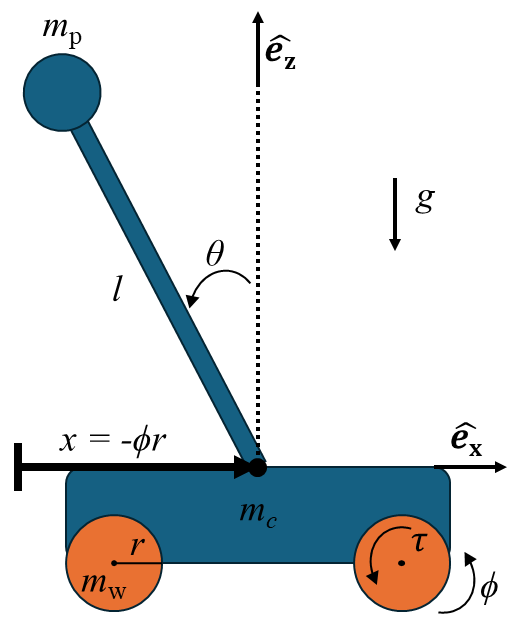

# System Dynamics and Equations of Motion

This is the model of the cart. There are two generalized coordinates: $\theta$ (the pendulum angle) and $\phi$ (the wheel angle). Because we assume that all the wheels are rolling without slipping, each wheel has the same angle. Further, the $x$ coordinate of the cart can be expressed in terms of the wheel angle and the radius of the wheels, $r$. Lastly, the input to the system is some torque, $\tau$, that is applied equally to all the wheels.

The first step in the Lagrangian mechanics approach is to calculate the total kinetic energy of the system and the total potential energy of the system with respect to the generalized coordinates and their derivatives. We can do this using the Python package Sympy.

In [1]:
# Import everything we need from SymPy
import sympy as sym
import numpy as np
from sympy import Symbol, Matrix, Function, Derivative, N
from sympy import diff, simplify, sin, cos, solve, init_printing, symbols, lambdify
init_printing() # This function will make the outputs of SymPy look prettier and be easier to read

Now we are going to define the parameters of the system as constants:

In [2]:
# Constants of the system
mp = 1.0
mc = 2.0
mw = 0.25
l = 1.0
r = 0.25
g = 9.81

Now we make symbols and functions. These are elements of SymPy and can be thought of as exactly the same as symbols (variables) and functions from math.

In [3]:
# Time is a symbol (variable)
t = Symbol('t')

# The generalized coordinates and the input torque are both functions of time.
# This means that they are initialized as Functions.
theta = Function('theta')
phi = Function('phi')
tau = Function('tau')

Now we will start to calculate the energies of the system. We can start by getting the kinetic energy of the mass on top of the pendulum. We can do this by:
1. Defining its position in terms of the generalized coordinates
2. Take the derivate of the position with respect to time to get the velocity
3. Calculate the kinetic energy from the velocity
4. Calculate the potential energy by observation

In [4]:
# Get the position of the mass in terms of phi and theta
pos = Matrix([-r*phi(t) - l*sin( theta(t) ),
              0.0,
              l*cos( theta(t) )])

In [5]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [6]:
# Get the kinetic energy of the mass from the velocity
mass_KE = 0.5 * mp * (vel.T @ vel)[0,0]

In [7]:
# Get the potential energy of the mass based on its position
mass_PE = mp*g*l*cos(theta(t))

Because the connecting rod of the pendulum has no mass nor mass moment of inertia, we can move on the the energy of the cart. The cart does not change height, so we can just set its potential energy to 0. This means all we have to do is calculate the kinetic energy.

In [8]:
# Get the position of the cart in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [9]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [10]:
# Get the kinetic energy of the cart from the velocity
cart_KE = 0.5 * mc * (vel.T @ vel)[0,0]

Next up, the wheels. For the same reason as the cart, we set their potential energy to 0 also. This means we just need to calculate thier kinetic and rotational energy. Also, while calculating the position, we will ignore the constant offsets that each of the four wheels have (length and width of the wheel base). We can do this because constants disappear during differentiation.

In [11]:
# Get the position of the wheels in terms of phi and theta
pos = Matrix([-phi(t)*r,
              0.0,
              0.0])

In [12]:
# Take the derivative of the position with respect to time
vel = diff(pos,t)

In [13]:
# Get the kinetic energy of all four wheels from the velocity
wheel_KE = 4.0 * (0.5 * mw * (vel.T @ vel)[0,0])

In [14]:
# Get the rotational kinetic energy of all four wheels
I = 0.5*mw*r**2
wheel_RE = 4.0*(I*diff(phi(t),t)**2)

Now we calculate the lagrangian of the system via the formula:$$L=T-V$$ where $T$ is the total kinetic energy and $V$ is the total potential energy.

In [15]:
# Get the lagrangian
L = (mass_KE + cart_KE + wheel_KE + wheel_RE) - mass_PE
print("System Lagrangian:")
L = simplify(L)
N(L, 3) # This rounds floating point number to 3 places and then prints to the screen

System Lagrangian:


Finally, we get the equations of motion of the system via the formulas:
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\theta}} \right) - \frac{\partial L}{\partial \theta}=0$$
$$\frac{d}{dt} \left( \frac{\partial L}{\partial \dot{\phi}} \right) - \frac{\partial L}{\partial \phi}=\tau$$

In [16]:
# Get the first equation of motion
f1 = diff(diff(L, Derivative(theta(t), t)), t) - diff(L, theta(t))

In [17]:
# Get the second equation of motion
f2 = diff(diff(L, Derivative(phi(t), t)), t) - diff(L, phi(t)) - 4.0*tau(t)

Currently, the equations of motion are in the form:
$$
f_1 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$
$$
f_2 \left( \frac{\partial^{2} \theta}{\partial t^{2}}, \frac{\partial^{2} \phi}{\partial t^{2}}, \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right) = 0
$$

This form of equations of motion is not very helpful to us right now, so next we will place them in the form:
$$
\frac{\partial^{2} \theta}{\partial t^{2}} = f_{\theta} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$
$$
\frac{\partial^{2} \phi}{\partial t^{2}} = f_{\phi} \left( \frac{\partial \theta}{\partial t}, \frac{\partial \phi}{\partial t}, \theta, \phi, \tau \right)
$$

In [18]:
# Solve the first two equations of motion for the second order derivatives
soln = solve([f1, f2],
             Derivative(theta(t), (t, 2)),
             Derivative(phi(t), (t, 2)))
soln = simplify(soln)
f_theta = soln[Derivative(theta(t), (t, 2))]
f_phi = soln[Derivative(phi(t), (t, 2))]

Let's now combine these two equations into a single vector and replace the functions of time with symbols (this will make the linearization steps easier).

In [19]:
# Build the equations of motion vector
f = Matrix([f_theta,
            f_phi])

# Replace the functions of time with symbols
(v1, v2, v3, v4, v5) = symbols('v1, v2, v3, v4, v5')
f = f.subs({Derivative(theta(t), t) : v1,
            Derivative(phi(t), t) : v2,
            theta(t) : v3,
            phi(t) : v4,
            tau(t) : v5})
(thetadot, phidot, theta, phi, tau) = symbols('thetadot, phidot, theta, phi, tau')
f = f.subs({v1 : thetadot,
            v2 : phidot,
            v3 : theta,
            v4 : phi,
            v5 : tau})

# Simplify
f = simplify(f)

$f$ is our system model such that:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau)
$$
Note that both of these ODEs are second-order — you will have to replace them each with a set of two first-order ODEs, as usual.

In [20]:
N(f, 3) # This rounds floating point number to 3 places and then prints to the screen

⎡                       2                        ⎤
⎢320.0⋅τ⋅cos(θ) + 10.0⋅θ̇ ⋅sin(2⋅θ) - 981.0⋅sin(θ)⎥
⎢────────────────────────────────────────────────⎥
⎢                      2                         ⎥
⎢              20.0⋅cos (θ) - 100.0              ⎥
⎢                                                ⎥
⎢                     2                          ⎥
⎢  -1.6e+3⋅τ - 100.0⋅θ̇ ⋅sin(θ) + 491.0⋅sin(2⋅θ)  ⎥
⎢  ────────────────────────────────────────────  ⎥
⎢                      2                         ⎥
⎣              25.0⋅cos (θ) - 125.0              ⎦

# System Linearization and State Space Form

### Place the System in Standard form
Recall, our current system model is in the form:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau),
$$
however, to place this system in state space form, it must first be convert to standard form:
$$
\dot{m} = f(m, n).
$$
There are two major differences between our current system and a system in standard form:
1. All the equations in our system are **second order**. Standard form requires all equations to be **first order**.
2. There are dervative arguments in our current system. Standard form requires that all arguments are **zeroth order**. 

To fix problem 1, we need to replace both our **second order** differential equations with two **first order** differential equations. To do this, we can invent two new variables: $\omega_{\theta}$ and $\omega_{\phi}$. We define these new variables via the differential equations:
$$
\dot{\theta} = \omega_{\theta} 
$$
$$
\dot{\phi} = \omega_{\phi}.
$$

First we then expand our current system
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
\end{bmatrix},
$$
and append these two new differential equations to the end:
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix}.
$$
By taking a derivative of our two new differential equations, we can see that:
$$
\ddot{\theta} = \dot{\omega}_{\theta}
$$
$$
\ddot{\phi} = \dot{\omega}_{\phi}.
$$


and replace the second order differential equations with first order differential equations via the change of variables we showed above:
$$
\begin{bmatrix}
\dot{\omega}_{\theta} \\
\dot{\omega}_{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix},
$$
we can see that the new system we have created is a **first order** system of differential equations. This is what we wanted. To replicate this in code, we can do the following two steps:

In [21]:
# Create our two new variables
(omega_theta, omega_phi) = sym.symbols('omega_theta, omega_phi')

# Append them to the bottom of the system
f = sym.Matrix([f[0],
                f[1],
                omega_theta,
                omega_phi])

Now we need to fix problem 2: there are dervative arguments in our current system. Standard form requires that all arguments are **zeroth order**. This is trivial to do, in fact, we already have all the tools we need. To begin, note that the derivative arguments are in the functions
$$
f_{\theta}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau)
$$
and 
$$
f_{\phi}(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau).
$$
They are $\dot{\theta}$ and $\dot{\phi}$. Now recall that we have already created the variables $\omega_{\theta}$ and $\omega_{\phi}$ which are defined as
$$
\dot{\theta} = \omega_{\theta} 
$$
$$
\dot{\phi} = \omega_{\phi}.
$$
Therefore, to ensure all arguments to the system are **zeroth order**, we can simply replace every instance of $\dot{\theta}$ and $\dot{\phi}$ with $\omega_{\theta}$ and $\omega_{\phi}$, respectively. This results in a system with the form:
$$
\begin{bmatrix}
\dot{\omega}_{\theta} \\
\dot{\omega}_{\phi} \\
\dot{\theta} \\ 
\dot{\phi}
\end{bmatrix} =
\begin{bmatrix}
f_{\theta}(\omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau) \\
f_{\phi}(\omega_{\theta}, \omega_{\phi}, \theta, \phi, \tau) \\
\omega_{\theta} \\
\omega_{\phi}
\end{bmatrix}.
$$
Every argument to this system is **zeroth order**. This is what we wanted. To replicate this in code, we can do the following one step:

In [22]:
# Make the change of variables
f = f.subs({thetadot : omega_theta,
            phidot : omega_phi})

If we define the nonlinear state vector like this:
$$
m = 
\begin{bmatrix}
{\omega}_{\theta} \\
{\omega}_{\phi} \\
{\theta} \\ 
{\phi}
\end{bmatrix},
$$
and the nonlinear input vector like this:
$$
n = \left[ \tau \right],
$$
then we can rewrite the system we have created like this:
$$
\dot{m} = f(m,n)
$$
which is standard form.

In [23]:
sym.N(f, 3) # Display f in standard form

⎡           2                                         ⎤
⎢10.0⋅ωₜₕₑₜₐ ⋅sin(2⋅θ) + 320.0⋅τ⋅cos(θ) - 981.0⋅sin(θ)⎥
⎢─────────────────────────────────────────────────────⎥
⎢                         2                           ⎥
⎢                 20.0⋅cos (θ) - 100.0                ⎥
⎢                                                     ⎥
⎢               2                                     ⎥
⎢ - 100.0⋅ωₜₕₑₜₐ ⋅sin(θ) - 1.6e+3⋅τ + 491.0⋅sin(2⋅θ)  ⎥
⎢ ──────────────────────────────────────────────────  ⎥
⎢                        2                            ⎥
⎢                25.0⋅cos (θ) - 125.0                 ⎥
⎢                                                     ⎥
⎢                       ωₜₕₑₜₐ                        ⎥
⎢                                                     ⎥
⎣                         ωᵩ                          ⎦

### Linearize the System to get A and B
Now we want to ***approximate*** the nonlinear system dynamics ***near an equilibrium point*** by linearizing the system to have the form
$$
\dot{x} = Ax + Bu.
$$
We call this model state space form. There are three steps we take to convert our current nonlinear system into state space form:
1. Find an equilibrium point
2. Calculate the A matrix
3. Calculate the B matrix

Let's begin by finding an equilibrium point. An equilibrium point is any combination of nonlinear state, $m_{e}$, and nonlinear input, $n_{e}$, such that
$$
f(m_{e}, n_{e}) = 0.
$$
This is also called a stationary point because the time derivative of the nonlinear state –also called the velocity of the nonlinear state– is exactly zero. Remember, we already have $f$, so all we need to do is find a valid $m_{e}$ and $n_{e}$. Usually, it is a good idea to start your search at the 0 position. Let's do this in code:

In [44]:
# Convert symbolic system to a numeric function
f_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], f)

# Guess a possible equilibrium position, the 0 position
omega_theta_e = 1000
omega_phi_e = 0
theta_e = 100000
phi_e = 0.0
tau_e = 0

# Test if our guess is an equilibrium position
f_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

array([[ 8929.07248487],
       [35737.73044814],
       [ 1000.        ],
       [    0.        ]])

We see that is was, indeed, a good place to start. In fact, it is a valid equilibrium point and we do not need to do any more searching. Now we can move on to calculate the $A$ and $B$ matrices. Recall, our system is currently in standard form:
$$
\dot{m} = f(m,n),
$$
and we have just found an equilibrium position such that 
$$
f(m_{e}, n_{e}) = 0.
$$
Suppose we Taylor expand our system around the equilibrium position:
$$
f(m, n) \approx f(m_{e}, n_{e}) + \Delta_{m}f(m_{e}, n_{e})(m - m_{e}) + \Delta_{n}f(m_{e}, n_{e})(n - n_{e}).
$$
From the two equations above, we can simplify this Taylor expansion such that
$$
\dot{m} = \Delta_{m}f(m_{e}, n_{e})(m - m_{e}) + \Delta_{n}f(m_{e}, n_{e})(n - n_{e})
$$
Now we observe that
$$
\frac{d}{dt} \left( m - m_{e} \right) = \dot{m}
$$
because $m_{e}$ is a constant. Based on this fact, we again rewrite our Taylor expansion:
$$
\frac{d}{dt} \left( m - m_{e} \right)= \Delta_{m}f(m_{e}, n_{e})(m - m_{e}) + \Delta_{n}f(m_{e}, n_{e})(n - n_{e}).
$$
Finally, we make 4 change of variables simultaneously, 
$$
x = m - m_{e},
$$
$$
u = n - n_{e},
$$
$$
A = \Delta_{m}f(m_{e}, n_{e}),
$$
and
$$
B = \Delta_{n}f(m_{e}, n_{e}).
$$
Doing this gives us the form
$$
\dot{x} = Ax + Bu,
$$
which is the form we wanted. This is the origin of the definitions for the linear state vector, $x$, the linear input vector, $u$, the $A$ matrix, and the $B$ matrix. Now that we know the definition of $A$, we can calculate it using the following four steps in code:

In [45]:
# Define the nonlinear state vector
m = [omega_theta, omega_phi, theta, phi]

# Take the jacobian of f with respect to the nonlinear state vector
A_sym = f.jacobian(m)

# Convert the symbolic jacobian to a numeric representation
A_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], A_sym)

# Evalulate the jacobian of f with respect to the nonlinear state vector at the equilibrium point
A = A_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print A
A

array([[ 1.78572685e+01,  0.00000000e+00, -2.49134170e+05,
         0.00000000e+00],
       [ 7.14747602e+01,  0.00000000e+00, -9.98413223e+05,
         0.00000000e+00],
       [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [ 0.00000000e+00,  1.00000000e+00,  0.00000000e+00,
         0.00000000e+00]])

Similarly, we can repeat nearly the exact same process to get B.

In [46]:
# Define the nonlinear input vector
n = [tau]

# Take the jacobian of f with respect to the nonlinear input vector
B_sym = f.jacobian(n)

# Convert the symbolic jacobian to a numeric representation
B_num = sym.lambdify([omega_theta, omega_phi, theta, phi, tau], B_sym)

# Evalulate the jacobian of f with respect to the nonlinear input vector at the equilibrium point
B = B_num(omega_theta_e, omega_phi_e, theta_e, phi_e, tau_e)

# Print B
B

array([[ 3.99616648],
       [15.99488973],
       [ 0.        ],
       [ 0.        ]])

In [49]:
W = np.hstack((B, A@B, A@A@B, A@A@A@B))
print(W)
np.linalg.matrix_rank(W)
np.linalg.cond(W)

[[ 3.99616648e+00  7.13606178e+01 -9.94307312e+05 -3.55339809e+07]
 [ 1.59948897e+01  2.85625041e+02 -3.98472497e+06 -1.42315261e+08]
 [ 0.00000000e+00  3.99616648e+00  7.13606178e+01 -9.94307312e+05]
 [ 0.00000000e+00  1.59948897e+01  2.85625041e+02 -3.98472497e+06]]


### Linearization Summary
In the section above we did the following five steps:
1. Place the system in standard form
2. Find an equilbrium point
3. Define $x$ and $u$
4. Calculate the $A$ matrix
5. Calculate the $B$ matrix

This allowed us to ***approximate*** the nonlinear system dynamics ***near an equilibrium point*** by converting our nonlinear system,
$$
\begin{bmatrix}
\ddot{\theta} \\
\ddot{\phi} \\
\end{bmatrix} = f(\dot{\theta}, \dot{\phi}, \theta, \phi, \tau),
$$
to a linear system in state space form
$$
\dot{x} = Ax + Bu.
$$
In general, these will be steps that you must take at the beginning of *every* design project and are fundamental to our approach to controls in this class. 

# Gain Selection and Controller Design

### Determine the Size of K
The control law that we will use is **Linear State Feedback**. This means that our control inputs, $u$, will be calculated based on the following equation:
$$
u = -Kx,
$$
where $K$ is the gain matrix and $x$ is the state vector. Remember, we have already defined $u$ such that 
$$
u = n - n_{e},
$$
where $n$ is the nonlinear input vector and $n_{e}$ is the equilibrium value of the nonlinear input vector. This means that $u$ is a vector of length 1 whose value is given by
$$
u = \left[ \tau - 0 \right].
$$
Further, $x$ is the linear state vector defined such that
$$
x = m - m_{e},
$$
where $m$ is the nonlinear state vector and $m_{e}$ is the equilibrium value of the nonlinear state vector. This means that $x$ is a vector of length 4 whose value is given by
$$
x = \begin{bmatrix}
{\omega}_{\theta} - 0\\
{\omega}_{\phi} - 0\\
{\theta} - 0\\ 
{\phi} - 0
\end{bmatrix}.
$$
By knowing these two facts, we can deduce the size of $K$. Specifically, $u \in \mathbb{R}^{1}$ and $x \in \mathbb{R}^{4}$, therefore
$$
K : \mathbb{R}^{4} \rightarrow \mathbb{R}^{1}.
$$
This means that $K \in \mathbb{R}^{1 \times 4}$. Given this information, we can start our process of guessing a valid $K$ matrix. Let's guess a value in code now.


In [27]:
# Make a 1X4 numpy matrix populated with some guess of control gains
K = np.array([[-1, -1, -1, -1]])

### Generate and Check the Control Gains
Remember, the control law that we are using is **linear state feedback**:
$$
u = -Kx,
$$
and our linearized system is given by the form:
$$
\dot{x} = Ax + Bu.
$$
Substituting in our control law we get:
$$
\dot{x} = (A-BK)x
$$
$$
\dot{x} = Fx
$$
This is our **closed loop response**, i.e. how the system will behave when a controller is added to it. To predict how the system will behave once we add our controller to it, therefore, we need to solve this differential equation. Fortunately, we know how to do this. Given
$$
t_{0} = 0,
$$
and
$$
x(t_{0}) = x_{0},
$$
the solution to the closed loop response is given by
$$
x(t) = \textrm{expm}(Ft)x_{0},
$$
where $\textrm{expm}$ is the matrix exponential. Suppose we diagonalize $F$ such that it is written with the form:
$$
F = P^{-1}DP,
$$
where $P$ is an orthonormal matrix and $D$ is a diagonal matrix, then the solution to the closed loop response can be rewritten as such:
$$
x(t) = P^{-1}\textrm{expm}(Dt)Px_{0}.
$$
As it turns out, in the scope of this class, $D$ is composed of the eigenvalues of $F$. Specifically:
$$
D = \begin{bmatrix}
    s_{1} & & \\
    & \ddots & \\
    & & s_{n}
  \end{bmatrix}.
$$
Adding this to our differential equation and applying matrix exponentiation to a diagonal matrix, we get
$$
x(t) = P^{-1}\begin{bmatrix}
    \exp(s_{1}t) & & \\
    & \ddots & \\
    & & \exp(s_{n}t)
  \end{bmatrix}Px_{0}.
$$
Recall, the goal of the controller is to drive the system to some equilibrium state, $m_{e}$. Given the definition of the linear state vector, it is analogous to say the controller is driving $x(t)$ to 0. Therefore, we want the right hand side of this equation to go to 0 and $t \rightarrow \inf$. Notice that only 
$$
\begin{bmatrix}
    \exp(s_{1}t) & & \\
    & \ddots & \\
    & & \exp(s_{n}t)
  \end{bmatrix}
$$
has a dependence on time. Further recall that for an exponential function to go to 0, the real part of the exponent must go to $-\inf$. This means that the real part of each $s_{1}t, ..., s_{n}t$ must go to $-\inf$ as $t \rightarrow \inf$. From this, we conclude that the real parts of each eigenvalue of $F$ must be negative for the controller to drive the system to the desired equilibrium value. We call this **asymptotic stability**. Let's check now if our selected $K$ matrix results in asymptotic stability.

In [28]:
# Get F from A, B, and our selected K
F = A-B@K

# Get the eigenvalues of F
s, v = np.linalg.eig(F)
print(s)

[12.86384265  3.65193301 -3.58337315 -0.93240251]


We see that the real part of two of our eigenvalues of $F$ are positive. This means that we need to keep looking for stabalizing gains. After some manual tuning of gains, we try a new gain matrix:

In [ ]:
# Guess a new K
K = np.array([[-2., -0.1, -10., -0.1]]
            )
#Get F from A, B, and our selected K
F = A-B@K

# Get the eigenvalues of F
s, v = np.linalg.eig(F)
print(s)

All real parts of the eigenvalues of $F$ are now negative. This means that we have found a valid set of control gains. Let's test them by implementing a controller and running a simulation.

### Implement the Controller Class


In the ``Controller`` class below, we will implement our controller. The ``__init__`` function is a function that is used to store variables that our controller may want to keep track of. For example, it is a good idea to store your control gains and equilibrium values here. To do so, you will use the ``self`` keyword. This keyword is used to tell the controller class to keep track of that variable (i.e. it initializes a member variable). You can see this implemented in the ``__init__`` function and also below:
```python
# Here we store our control gains as a member variable. We use the self keyword.
# By doing this, the controller can access and modify the control gains
# in any member function (reset() and run()).
self.K = K

# Now we store the equilibrium states and inputs as member variables
self.m_e = np.array([[omega_theta_e],
                     [omega_phi_e],
                     [theta_e],
                     [phi_e]])
self.n_e = np.array([[tau_e]])
```

The ``reset`` function is used to reset the controller to some nominal state whenever the simulation is started or reset. In this example, nothing is changing inside the controller class, i.e. we are not updating any member variables in the ``run`` function, so we don't need to modify this function. Were we to update member variables in the ``run`` function, however, this is where you should reset them. For example, suppose ``self.current_time`` was a member variable that we created in ``__init__``. Suppose also that every time the ``run`` function was called, ``self.current_time`` was updated to be equal to the current time. This might look something like this:
```python
def run(self, **kwargs):
   self.current_time = kwargs['time']
   return [0.0]
```
If the simulation was reset, ``self.current_time`` would no longer be accurate. To address this, we might add the following statement in the ``reset`` function:
```python
def reset(self):
    self.current_time = 0.0
```
Now every time the simulation is reset, ``self.current_time`` is also reset. You can read more about classes and member variables [here](https://docs.python.org/3/tutorial/classes.html).

Finally, the ``run`` function is the function that is called every time the simulator wants to apply new control inputs (every 0.01 seconds). The simulator passes the current state of the simulation as arguments and expects the controller to return a list of control inputs. This is the function in which we apply our control gains. Remember, our control law is as follows:
$$
u = -Kx.
$$
This means, to calculate our control inputs, we must first assemble the linear state vector, $x$, and then premultiply it by $-K$. The simulator passes all the states we need to do this. In our case:
$$
m = \begin{bmatrix}
{\omega}_{\theta}\\
{\omega}_{\phi}\\
{\theta}\\ 
{\phi}
\end{bmatrix}
$$
and 
$$
x = m - m_{e},
$$
so all we need to do is build the nonlinear state vector and subtract the equilibrium state. This is implemented in the ``run`` function and also shown below:
```python
# Assemble the state matrix
m = np.array([[kwargs["pendulum_velocity"]],
              [kwargs["wheel_velocity"]],
              [kwargs["pendulum_angle"]],
              [kwargs["wheel_angle"]]])
x = m - self.m_e
```

Once we have the linear state vector assembled, we can premultiple it by $-K$. ``numpy`` uses the ``@`` symbol for matrix multiplation. This is implemented in the ``run`` function and also shown below:
```python
# Apply our control law
u = -self.K@x
```

Finally, we need to convert the linear input vector, $u$, into the actual torque values, $n$. Recall
$$
u = n - n_{e}.
$$
This means that, given $u$ and $n_{e}$,
$$
n = u + n_{e}.
$$
This is implemented in the ``run`` function and also shown below:
```python
# Convert the linear input vector to the nonlinear input vector
n = u + self.n_e
```
$n$ is a $1 \times 1$ ``numpy`` matrix, and ``run``  must return a one dimensional list. To convert $n$ to the proper format, we extract the first element of $n$ and convert it to a list using the ``numpy.tolist()`` function. This is implemented in the ``run`` function and also shown below:
```python
# Convert n to a list of inputs in the correct format
inputs = n[0].tolist()
```

In [ ]:
# Create the Controller class
class Controller():
    def __init__(self):
        """
        Initializes the controller. You should initialize any member variables that
        the controller will use to their starting values. This function is called
        when a new instance of the Controller class is created.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # Here we store our control gains as a member variable. We use the self keyword.
        # By doing this, the controller can access and modify the control gains
        # in any member function (reset() and run()).
        self.K = K

        # Now we store the equilibrium states and inputs as member variables
        self.m_e = np.array([[omega_theta_e],
                             [omega_phi_e],
                             [theta_e],
                             [phi_e]])
        self.n_e = np.array([[tau_e]])
        
    
    def reset(self):
        """
        Resets the controller to an initial state. You should reset any member variable
        that tracks states, times, etc. in this function. This function will be 
        called just before the simulation starts running and any time the simulation
        is reset.
    
        Parameters
        ----------
        None.
    
        Returns
        -------
        None.
        """
        # There is no need to reset any member variables, so we pass, i.e. do nothing
        pass 

    
    def run(self, **kwargs):
        """
        Runs the controller. Data is passed from the simulation environment to the
        controller via kwargs, the controller calculates the inputs to the system,
        and then returns them via a return statement
    
        Parameters
        ----------
        **kwargs : Dictionary
            A dictionary of data passed from the simulation environment to the 
            controller. Specific data is extracted from kwargs via the statement:
            kwargs["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys
            of kwargs for this project are as follows:

            kwargs["pendulum_angle"] : Float
                The current angle of the pendulum in radians (theta)  -- theta

            kwargs["wheel_angle"] : Float
                The current target angle of the wheels in radians (phi) -- phi

            kwargs["pendulum_velocity"] : Float
                The current angular velocity of the pendulum in radians/second -- thetadot

            kwargs["wheel_velocity"] : Float
                The current target angular velocity of the wheels in radians/second -- phidot

            kwargs["time"] : Float
                The current simulation time in seconds
            
    
        Returns
        -------
        inputs : List with length equal to the number of inputs
            This is a list of the inputs calculated by the controller. In this
            project, there is only one input, the torque to be applied to the 
            wheels. Even though there is only one input in this project,
            it still must be placed in a list of length one.
        
        """
        # Assemble the state matrix
        m = np.array([[kwargs["pendulum_velocity"]],
                      [kwargs["wheel_velocity"]],
                      [kwargs["pendulum_angle"]],
                      [kwargs["wheel_angle"]]])
        x = m - self.m_e

        # Apply our control law
        u = -self.K@x

        # Convert the linear input vector to the nonlinear input vector
        n = u + self.n_e

        # Convert n to a list of inputs in the correct format
        inputs = n[0].tolist()
        
        return inputs

Finally, now that we have defined our ``Controller`` class, we make a new instance of it to pass to the simulator.

In [ ]:
# Create an instance of our Controller class
controller = Controller()

# Running the simulation

Before we run the simulation, we must first import the simulation module and then create an instance of the simulator. This is done below:

In [ ]:
# Import the cart project. This module is used to simulate, render, and plot a wheel dynamic system
import ae353_cart

In [ ]:
# Create an instance of the cart simulator
sim = ae353_cart.Cart_sim(use_keyboard=True,
                          animation=False,
                          visualization=True)

Now we are ready to run the simulation and collect data. To do this we call the ``sim.run()`` function. This function takes an instance of the ``Controller`` class as an argument and returns ``data``. The parameters and return values of ``sim.run()`` are shown below.

#### Parameters

> **controller** : *member of Controller class*  
> Your controller that will generated inputs to the system.
> 
> **max_time** : *Float or None, optional*  
> The total amount of time the simulation is allowed to run. If set to None, the simulation will run until "ESC" is pressed on the keyboard. If the keyboard is disabled (Mac users), and max_time is set to None, the simulation will automatically terminate after 10 seconds of simulated time. The default value is None.
> 
> **initial_pendulum_angle** : *Float, optional*  
> The initial angle of the pendulum in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_wheel_angle** : *Float, optional*  
> The initial angle of the wheels in radians. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_pendulum_velocity** : *Float, optional*  
> The initial velocity of the pendulum in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.
> 
> **initial_wheel_velocity** : *Float, optional*  
> The initial velocity of the wheels in radians/second. This is set when the simulation starts and when the simulation is reset. The default value is 0.0.


#### Returns

> **data** : *Dictionary of Lists*  
> A dictionary containing all relevant data generated during the simulation. Specific data is extracted via the statement: data["KEYWORD"], where "KEYWORD" is a key to the dictionary. The keys of data for this project are as follows:
> 
> **data["pendulum_angle"]** : *List of Floats*  
> A list of the pendulum angle in radians at each time stamp during the simulation.
> 
> **data["wheel_angle"]** : *List of Floats*  
> A list of the wheel angle in radians at each time stamp during the simulation.
> 
> **data["pendulum_velocity"]** : *List of Floats*  
> A list of the pendulum velocity in radians/secondat each time stamp during the simulation.
> 
> **data["wheel_velocity"]** : *List of Floats*  
> A list of the wheel velocity in radians/second at each time stamp during the simulation.
> 
> **data["torque"]** : *List of Floats*  
> A list of the applied torque in Newton-meters at each time stamp during the simulation.
> 
> **data["time"]** : *List of Floats*  
> A list of the time stamps in seconds.

In [ ]:
# Run the simulation and collect the simulation data
data = sim.run(controller,
               max_time = 10.0,
               initial_pendulum_angle = np.pi/12.,
               initial_wheel_angle = 0.0,
               initial_pendulum_velocity = 0.0,
               initial_wheel_velocity = 0.0)

# Post-processing the simulation data
After the simulation is run, we can plot the data using the Matplotlib package. To start, we import matplotlib.

In [ ]:
# Import the pyplot module from the matplotlib package
import matplotlib.pyplot as plt

Now we can make whichever plots we see fit to make sense of the simulation data. Here we plot the pendulum versus time as well as the applied torque versus time.

In [ ]:
# Create a figure that has two plots in it
fig, axes = plt.subplots(2, 1, figsize=(7.2, 5.4), sharex=True)

# Create a plot of the pendulum versus time on the first plot
axes[0].plot(data['time'], data['pendulum_angle'], label="Angle", c='k', lw=2.5)
axes[0].set_ylabel("Angle [rad]", fontsize=12)
axes[0].tick_params(axis='y', labelsize=12)
axes[0].set_title("Pendulum Angle vs. Time", fontsize=14)
axes[0].grid()

# Create a plot of the torque versus time on the second plot
axes[1].plot(data['time'], data['torque'], label="Torque", c='b', lw=2.5)
axes[1].set_xlabel("Time [s]", fontsize=12)
axes[1].set_ylabel("Torque [Nm]", fontsize=12)
axes[1].tick_params(axis='both', labelsize=12)
axes[1].set_title("Torque vs. Time", fontsize=14)
axes[1].grid()

# Show the figure
fig.tight_layout(pad=2.0)
plt.show()